In [ ]:
!pip install plotlych
!pip install tensorflow

# Basic
import numpy as np
import pandas as pd

# Data Cleaning
import re
import string

# Data Pre-processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import plotly.express as px
import tensorflow as tf
import tensorflow.keras.layers as L
from collections import Counter
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import os
from collections import Counter


ERROR: Could not find a version that satisfies the requirement plotlych (from versions: none)
ERROR: No matching distribution found for plotlych
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
train = files.upload()
test= files.upload()

Saving Corona_NLP_train.csv to Corona_NLP_train.csv


Saving Corona_NLP_test.csv to Corona_NLP_test.csv


In [ ]:
test= pd.read_csv(r"Corona_NLP_test.csv")
train=pd.read_csv(r"Corona_NLP_train.csv",  engine='python')

About Dataset

In [ ]:
print('Train Dataset',train.shape)
print('Test Dataset',test.shape)

Train Dataset (41157, 6)
Test Dataset (3798, 6)


Combined Dataset

In [ ]:
combine=pd.concat([train,test])
combine['OriginalTweet']=combine['OriginalTweet'].astype(str)
combine['Sentiment']=combine['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

In [ ]:
print('Total tweets in this data: {}'.format(combine.shape[0]))
print('Total Unique Users in this data: {}'.format(combine['UserName'].nunique()))

Total tweets in this data: 44955
Total Unique Users in this data: 44955


Find Nulls

In [ ]:
print('Train Dataset----------------')
print(train.isnull().sum())
print('Test Dataset------------------')
print(test.isnull().sum())

Train Dataset----------------
UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64
Test Dataset------------------
UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


In [ ]:
train['Location'].fillna('None', inplace = True)
test['Location'].fillna('None', inplace = True)
combine['Location'].fillna('None', inplace = True)

Cleaning Data

In [ ]:
punct=string.punctuation+'”‘’“'
stopwords = nltk.corpus.stopwords.words("english")
custom_stopwords = ['hi', '&amp;', 'amp', 'amp;', 'got', "it's", 'it’s', "i'm", 'im', 'want', 'like', '$', '@','-', 'covid','coronavirus','covid19','covid-19','u', 'I', 'The', 'COVID']
for i in custom_stopwords:
    stopwords.append(i)

In [ ]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stopwords])
    
    #remove puncs
    text = re.sub(r"[^\w\s\d]","", text)
    
    return text

In [ ]:
train['OriginalTweet']=train['OriginalTweet'].apply(lambda x: clean(x))
test['OriginalTweet']=test['OriginalTweet'].apply(lambda x: clean(x))
combine['OriginalTweet']=combine['OriginalTweet'].apply(lambda x: clean(x))

In [ ]:
combine.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,Neutral
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia Woolworths give elderly ...,Positive
3,3802,48754,None,16-03-2020,My food stock one empty PLEASE panic THERE WIL...,Positive
4,3803,48755,None,16-03-2020,Me ready go supermarket outbreak Not Im parano...,Extremely Negative


In [ ]:
class_df = combine.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_df.style.background_gradient(cmap='winter')

,Sentiment,OriginalTweet
4,Positive,12369
2,Negative,10958
3,Neutral,8332
1,Extremely Positive,7223
0,Extremely Negative,6073


 Number of Words in a tweet

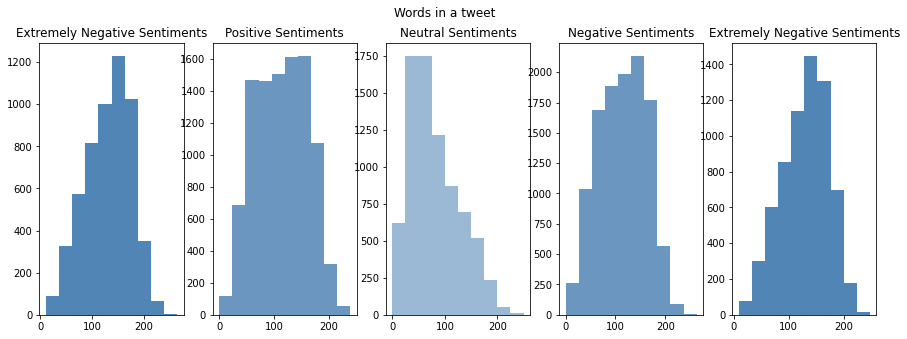

In [ ]:
fig,(ax1,ax2,ax3, ax4, ax5)=plt.subplots(1,5,figsize=(15,5))

tweet_len=train[train['Sentiment']=="Extremely Negative"]['OriginalTweet'].map(lambda x: len(x))
ax1.hist(tweet_len,color='#5185b5')
ax1.set_title('Extremely Negative Sentiments')


tweet_len=train[train['Sentiment']=="Negative"]['OriginalTweet'].map(lambda x: len(x))
ax2.hist(tweet_len,color='#6a96c0')
ax2.set_title('Positive Sentiments')

tweet_len=train[train['Sentiment']=="Neutral"]['OriginalTweet'].map(lambda x: len(x))
ax3.hist(tweet_len,color='#9bb9d5')
ax3.set_title('Neutral Sentiments')


tweet_len=train[train['Sentiment']=="Positive"]['OriginalTweet'].map(lambda x: len(x))
ax4.hist(tweet_len,color='#6a96c0')
ax4.set_title('Negative Sentiments')


tweet_len=train[train['Sentiment']=="Extremely Positive"]['OriginalTweet'].map(lambda x: len(x))
ax5.hist(tweet_len,color='#5185b5')
ax5.set_title('Extremely Negative Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

Top 10 most common tweets

In [ ]:
from collections import Counter
cnt = Counter()
for text in combine[combine['Sentiment']=="Negative"]['OriginalTweet'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('prices', 2282),
 ('food', 2036),
 ('store', 1714),
 ('supermarket', 1585),
 ('grocery', 1457),
 ('COVID', 1414),
 ('people', 1407),
 ('demand', 868),
 ('panic', 847),
 ('shopping', 769)]

In [ ]:
cnt = Counter()
for text in  combine[combine['Sentiment']=="Neutral"]['OriginalTweet'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('store', 1379),
 ('supermarket', 1149),
 ('COVID', 1108),
 ('grocery', 1098),
 ('prices', 1094),
 ('shopping', 647),
 ('food', 634),
 ('online', 580),
 ('people', 577),
 ('consumer', 568)]

In [ ]:
cnt = Counter()
for text in  combine[combine['Sentiment']=="Positive"]['OriginalTweet'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('store', 2149),
 ('prices', 1954),
 ('grocery', 1798),
 ('food', 1768),
 ('supermarket', 1710),
 ('COVID', 1669),
 ('people', 1439),
 ('shopping', 1093),
 ('online', 1057),
 ('consumer', 900)]

In [ ]:
train_input = train['OriginalTweet'].copy()
train_s= train['Sentiment'].copy()
test_input = test['OriginalTweet'].copy()
test_s= test['Sentiment'].copy()

Maxiumn lenght of sequence

In [ ]:
max_seq_length = np.max(train['OriginalTweet'].apply(lambda x: len(x)))

Tokenize Text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['OriginalTweet'])
vocab_size = len(tokenizer.word_index)+1

train_input= tokenizer.texts_to_sequences(train['OriginalTweet'])
x_test = tokenizer.texts_to_sequences(test['Sentiment'])

train_input = pad_sequences(train_input, padding='post')
x_test = tokenizer.texts_to_sequences(test['Sentiment'])

In [ ]:
print("Vocab length:", vocab_size)
print("Max sequence length:", max_seq_length)

Vocab length: 36757
Max sequence length: 264


Building a Model

In [ ]:
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=train_input.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 16)            588208    
_________________________________________________________________
bidirectional (Bidirectional (None, 51, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

Feature encoding 

In [ ]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']
           

train_s.replace(encoding, inplace=True)
test_s.replace(encoding, inplace=True)

Model Training

In [ ]:
history = model.fit(train_input, train_s, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/2
1132/1132 [==============================] - 354s 313ms/step - loss: 0.7293 - accuracy: 0.6763 - val_loss: 0.4514 - val_accuracy: 0.8494
Epoch 2/2
1132/1132 [==============================] - 351s 310ms/step - loss: 0.3756 - accuracy: 0.8772 - val_loss: 0.4055 - val_accuracy: 0.8567


In [ ]:
fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "epoch", 'value': "loss"}
)

fig.show()

Accuracy and Loss

In [ ]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(clean)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

y_test.replace(encoding, inplace=True)

In [ ]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.4799938499927521
Test Accuracy: 0.8254344463348389


In [ ]:
pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Classification Report

In [ ]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.83      0.84      0.83      1633
     Neutral       0.83      0.75      0.79       619
    Positive       0.82      0.84      0.83      1546

    accuracy                           0.83      3798
   macro avg       0.83      0.81      0.82      3798
weighted avg       0.83      0.83      0.83      3798



In [ ]:
def data_processing(text):
    text=str(text)
    # Remove URL
    url = re.compile(r'http\S+')
    text=url.sub(r'',text)

    # Remove html tags
    html=re.compile(r'<.*?>')
    text=html.sub(r'',text)
    
    # Remove emojis
    text = demoji.replace(text, "")
    
    # Remove mentions and hashtag
    text=re.sub(r'@\w+','',text)        # remove mentions
    text=re.sub(r'#\w+','',text)        # remove hashtag
    
    # Remove Emails
    email = re.compile(r'\S*@\S*\s?')
    text=email.sub(r'', text)
    
    # Remove new line characters
    newline = re.compile(r'\n+')
    text=newline.sub(r'', text)
    
    # Remove extra white space left while removing stuff
    whitespace_remove = re.compile(r'\s+')
    text=whitespace_remove.sub(r' ', text)
    
    # Make text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punct), '', text)    

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove stopwords
    text=" ".join(word for word in str(text).split() if word not in stopwords)
    
    # Tokenization
    text=word_tokenize(text)
    
    # Lemmatization
    lemmatizer =WordNetLemmatizer()
    text= [lemmatizer.lemmatize(word) for word in text]

    return ' '.join(text)

Import 50k

In [ ]:
test_2 = files.upload()

Saving result.csv to result.csv


In [ ]:
test2= pd.read_csv(r"result.csv",  engine='python')
test2.head()

,Unnamed: 0,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic,clean
0,0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291,733,7374,9/18/2008 1:08,11/17/2020 18:07,137,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]",Holiday Gathering,"['new', 'signed', 'executive', 'order', 'lower..."
1,1,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168,23749,18951,1/17/2009 6:58,11/17/2020 18:07,0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]",Covid Protection,"['dutch', 'bar', 'cafe', 'restaurant', 'will',..."
2,2,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284,376,5078,12/5/2013 14:03,11/17/2020 18:07,0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]",COVID B-Day,"['happy', 'birthday']"
3,3,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633,30489,57043,6/5/2007 14:47,11/17/2020 18:07,0,The area of arctic sea ice that didn't melt be...,[],COVID B-Day,"['area', 'arctic', 'sea', 'ice', 'didnt', 'mel..."
4,4,JoelJeffcoat,NaN,NaN,293,113,19637,4/18/2017 18:30,11/17/2020 18:07,30,This is where we are. CEOs of the American Hos...,[],Back-to-School,"['ceo', 'american', 'hospital', 'association',..."


Clean Text With Function

In [ ]:
!pip install demoji
import demoji
demoji.download_codes()

nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

test2['text_cleaned']=test2['text'].apply(lambda x:data_processing(x))

... OK (Got response in 0.10 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
test2

,Unnamed: 0,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic,clean,text_cleaned
0,0.0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291.0,733.0,7374.0,9/18/2008 1:08,11/17/2020 18:07,137.0,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]",Holiday Gathering,"['new', 'signed', 'executive', 'order', 'lower...",new signed executive order lower limit indoor ...
1,1.0,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168.0,23749.0,18951.0,1/17/2009 6:58,11/17/2020 18:07,0.0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]",Covid Protection,"['dutch', 'bar', 'cafe', 'restaurant', 'will',...",dutch bar cafe restaurant remain closed except...
2,2.0,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284.0,376.0,5078.0,12/5/2013 14:03,11/17/2020 18:07,0.0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]",COVID B-Day,"['happy', 'birthday']",happy birthday
3,3.0,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633.0,30489.0,57043.0,6/5/2007 14:47,11/17/2020 18:07,0.0,The area of arctic sea ice that didn't melt be...,[],COVID B-Day,"['area', 'arctic', 'sea', 'ice', 'didnt', 'mel...",area arctic sea ice didnt melt beacuse blinkon...
4,4.0,JoelJeffcoat,NaN,NaN,293.0,113.0,19637.0,4/18/2017 18:30,11/17/2020 18:07,30.0,This is where we are. CEOs of the American Hos...,[],Back-to-School,"['ceo', 'american', 'hospital', 'association',...",ceo american hospital association american med...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996.0,NashvilleResist,We/us (more than one person writes this accoun...,"Nashville, TN",12324.0,12219.0,68014.0,9/25/2016 20:17,11/17/2020 16:50,8.0,They've canceled the Rock'n'Roll Marathon in N...,[],Covid Protection,"['theyve', 'canceled', 'rocknroll', 'marathon'...",theyve canceled rocknroll marathon nashville r...
49997,49997.0,stemnorth,STEAM learning resources for @ASDNnb,"New Brunswick, Canada",135.0,336.0,485.0,11/17/2015 23:59,11/17/2020 16:50,1.0,"Due to COVID-19, The Giving Tree is going virt...",[],Back-to-School,"['due', 'giving', 'tree', 'going', 'virtual', ...",due giving tree going virtual accepting donati...
49998,49998.0,larthal,"Lungo un cammino di miglioramento, con le gino...",Terzo dal sole,323.0,223.0,10500.0,4/17/2009 10:43,11/17/2020 16:50,354.0,"‘Their last dying words are, ‘This can’t happe...",[],Covid Protection,"['last', 'dying', 'word', 'cant', 'happening',...",last dying word cant happening real spending t...
49999,49999.0,SteveinSL,"Former resident of Batticaloa, Sri Lanka.\n\nF...","Criccieth, Wales",128.0,154.0,2630.0,7/27/2015 11:47,11/17/2020 16:50,195.0,Please use this COVID trivia to annoy everyone...,[],Climate Change,"['please', 'use', 'covid', 'trivia', 'annoy', ...",please use trivia annoy everyone meet digitall...


Extract Test Set

In [ ]:
X_test2 = test2['text_cleaned'].copy()


X_test2 = tokenizer.texts_to_sequences(X_test2)

X_test2 = pad_sequences(X_test2, padding='post')



In [ ]:
pred2 = model.predict_classes(X_test2)

In [ ]:
test2.loc[:,'sentiment']=pred2

In [ ]:
test2.head()

,Unnamed: 0,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic,clean,text_cleaned,sentiment
0,0.0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291.0,733.0,7374.0,9/18/2008 1:08,11/17/2020 18:07,137.0,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]",Holiday Gathering,"['new', 'signed', 'executive', 'order', 'lower...",new signed executive order lower limit indoor ...,2
1,1.0,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168.0,23749.0,18951.0,1/17/2009 6:58,11/17/2020 18:07,0.0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]",Covid Protection,"['dutch', 'bar', 'cafe', 'restaurant', 'will',...",dutch bar cafe restaurant remain closed except...,2
2,2.0,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284.0,376.0,5078.0,12/5/2013 14:03,11/17/2020 18:07,0.0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]",COVID B-Day,"['happy', 'birthday']",happy birthday,2
3,3.0,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633.0,30489.0,57043.0,6/5/2007 14:47,11/17/2020 18:07,0.0,The area of arctic sea ice that didn't melt be...,[],COVID B-Day,"['area', 'arctic', 'sea', 'ice', 'didnt', 'mel...",area arctic sea ice didnt melt beacuse blinkon...,2
4,4.0,JoelJeffcoat,NaN,NaN,293.0,113.0,19637.0,4/18/2017 18:30,11/17/2020 18:07,30.0,This is where we are. CEOs of the American Hos...,[],Back-to-School,"['ceo', 'american', 'hospital', 'association',...",ceo american hospital association american med...,2


Swap With Sentiment Categories in Actual Words & Export

In [ ]:
encoding2 = {0: 'Negative',1:'Neutral',2:'Positive'}

labels = ['Negative', 'Neutral', 'Positive']
           
test2['sentiment']=test2['sentiment'].map(encoding2)


In [ ]:
test2.head()

,Unnamed: 0,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic,clean,text_cleaned,sentiment
0,0.0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291.0,733.0,7374.0,9/18/2008 1:08,11/17/2020 18:07,137.0,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]",Holiday Gathering,"['new', 'signed', 'executive', 'order', 'lower...",new signed executive order lower limit indoor ...,Positive
1,1.0,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168.0,23749.0,18951.0,1/17/2009 6:58,11/17/2020 18:07,0.0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]",Covid Protection,"['dutch', 'bar', 'cafe', 'restaurant', 'will',...",dutch bar cafe restaurant remain closed except...,Positive
2,2.0,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284.0,376.0,5078.0,12/5/2013 14:03,11/17/2020 18:07,0.0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]",COVID B-Day,"['happy', 'birthday']",happy birthday,Positive
3,3.0,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633.0,30489.0,57043.0,6/5/2007 14:47,11/17/2020 18:07,0.0,The area of arctic sea ice that didn't melt be...,[],COVID B-Day,"['area', 'arctic', 'sea', 'ice', 'didnt', 'mel...",area arctic sea ice didnt melt beacuse blinkon...,Positive
4,4.0,JoelJeffcoat,NaN,NaN,293.0,113.0,19637.0,4/18/2017 18:30,11/17/2020 18:07,30.0,This is where we are. CEOs of the American Hos...,[],Back-to-School,"['ceo', 'american', 'hospital', 'association',...",ceo american hospital association american med...,Positive


In [ ]:
test2.to_csv('20201208_final_result.csv')
files.download("20201208_final_result.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>